총 시퀀스 수: 629
상위 5개 예시:
01April_2010_Thursday_heute_default-5: 132 frames
01April_2010_Thursday_tagesschau_default-7: 144 frames
01April_2010_Thursday_tagesschau_default-8: 158 frames
01April_2011_Friday_tagesschau_default-0: 116 frames
01April_2011_Friday_tagesschau_default-14: 156 frames
프레임 수 범위: 39 ~ 251
평균 프레임 수: 142.24


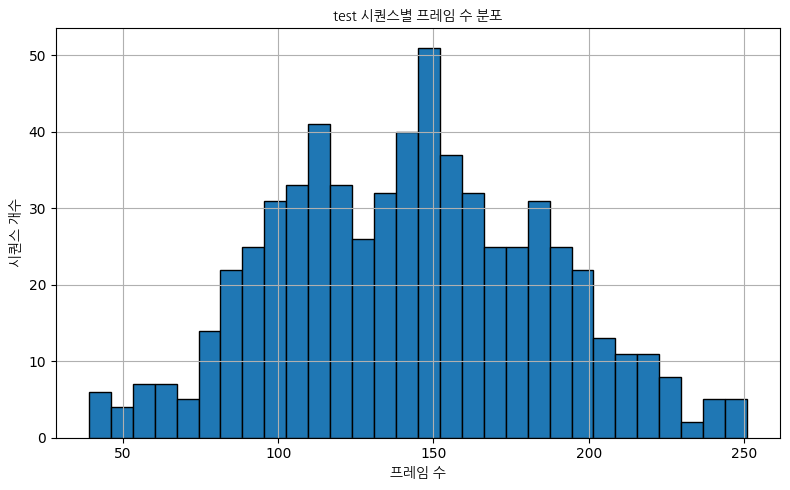

In [6]:
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# train 디렉토리
base_dir = '/home/jhy/SignGraph/phoenix2014-release/phoenix-2014-multisigner/features/fullFrame-210x260px/test'

# 시퀀스별 프레임 수 저장
sequence_lengths = {}

for seq_folder in sorted(os.listdir(base_dir)):
    seq_path = os.path.join(base_dir, seq_folder)
    if os.path.isdir(seq_path):
        total_frames = 0
        # seq_path 내부의 모든 하위 폴더 탐색
        for inner_folder in os.listdir(seq_path):
            inner_path = os.path.join(seq_path, inner_folder)
            if os.path.isdir(inner_path):
                pngs = [f for f in os.listdir(inner_path) if f.lower().endswith('.png')]
                total_frames += len(pngs)
        sequence_lengths[seq_folder] = total_frames

# 결과 출력
print(f"총 시퀀스 수: {len(sequence_lengths)}")
print("상위 5개 예시:")
for k, v in list(sequence_lengths.items())[:5]:
    print(f"{k}: {v} frames")

# 통계 계산
frame_counts = list(sequence_lengths.values())
print(f"프레임 수 범위: {min(frame_counts)} ~ {max(frame_counts)}")
print(f"평균 프레임 수: {sum(frame_counts) / len(frame_counts):.2f}")

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(frame_counts, bins=30, edgecolor='black')
plt.title('test 시퀀스별 프레임 수 분포', fontproperties=font_prop)
plt.xlabel('프레임 수', fontproperties=font_prop)
plt.ylabel('시퀀스 개수', fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import os
import csv

# 경로 설정
base_dir = '/home/jhy/SignGraph/phoenix2014-release/phoenix-2014-multisigner/features/fullFrame-210x260px/test'
output_file = 'test_frame_annotations.csv'

# 결과 기록
annotations = []

for seq_folder in sorted(os.listdir(base_dir)):
    seq_path = os.path.join(base_dir, seq_folder)
    if os.path.isdir(seq_path):
        total_frames = 0
        for inner_folder in os.listdir(seq_path):
            inner_path = os.path.join(seq_path, inner_folder)
            if os.path.isdir(inner_path):
                pngs = [f for f in os.listdir(inner_path) if f.lower().endswith('.png')]
                total_frames += len(pngs)
        annotations.append((seq_folder, total_frames))

# 파일로 저장
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['sequence_name', 'frame_count'])
    writer.writerows(annotations)

print(f"✅ 어노테이션 파일 저장 완료: {output_file}")
print(f"총 시퀀스 수: {len(annotations)}")


✅ 어노테이션 파일 저장 완료: test_frame_annotations.csv
총 시퀀스 수: 629


In [3]:
import pandas as pd

# 1. frame count 파일 불러오기
frame_df = pd.read_csv('test_frame_annotations.csv')

# 2. gloss 정보가 있는 corpus.csv 불러오기
gloss_df = pd.read_csv('/home/jhy/SignGraph/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/test.corpus.csv', sep='|')

# 3. 필요한 컬럼 추출 및 gloss_count 계산
gloss_df = gloss_df[['id', 'annotation']]
gloss_df = gloss_df.rename(columns={'id': 'sequence_name', 'annotation': 'gloss'})
gloss_df['gloss_count'] = gloss_df['gloss'].apply(lambda x: len(str(x).split()))

# 4. merge (sequence_name 기준)
merged = pd.merge(frame_df, gloss_df, on='sequence_name', how='left')

# 5. 저장
output_path = 'test_frame_annotations_with_gloss.csv'
merged.to_csv(output_path, index=False)

print(f"✅ 저장 완료: {output_path}")
print(merged.head())


✅ 저장 완료: test_frame_annotations_with_gloss.csv
                                sequence_name  frame_count  \
0       01April_2010_Thursday_heute_default-5          132   
1  01April_2010_Thursday_tagesschau_default-7          144   
2  01April_2010_Thursday_tagesschau_default-8          158   
3    01April_2011_Friday_tagesschau_default-0          116   
4   01April_2011_Friday_tagesschau_default-14          156   

                                               gloss  gloss_count  
0             ABER FREUEN  MORGEN SONNE SELTEN REGEN            6  
1  SAMSTAG WECHSELHAFT BESONDERS FREUNDLICH NORDO...            7  
2    SONNTAG REGEN TEIL GEWITTER SUEDOST DURCH REGEN            7  
3  __ON__ JETZT WETTER WIE-AUSSEHEN MORGEN SAMSTA...           12  
4  __ON__ MONTAG UEBERALL WECHSELHAFT ABER KUEHL ...           15  


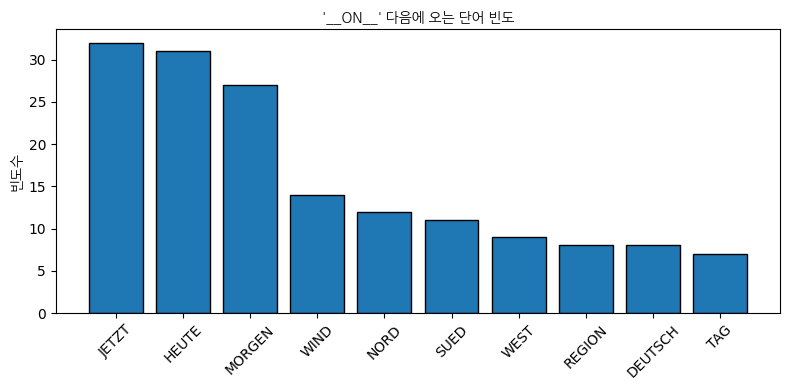

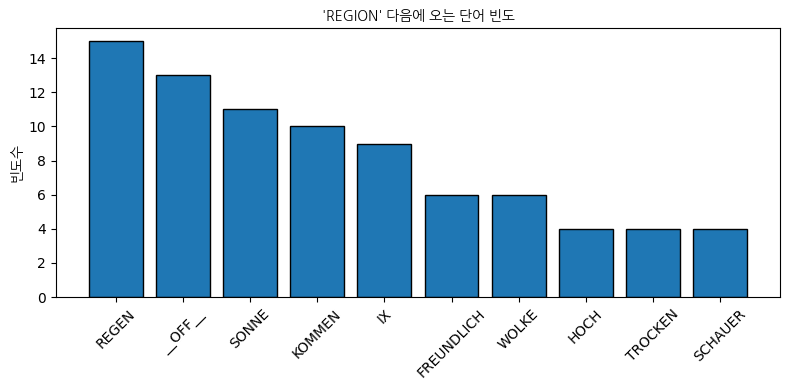

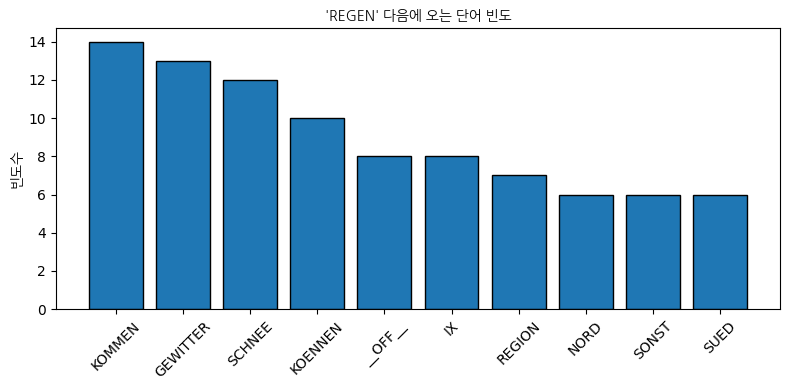

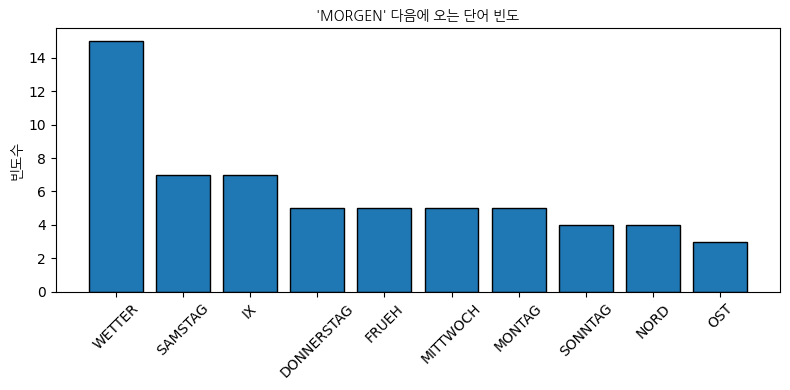

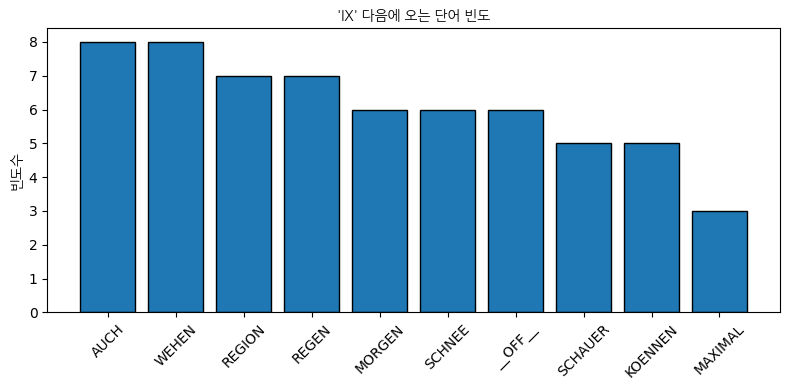

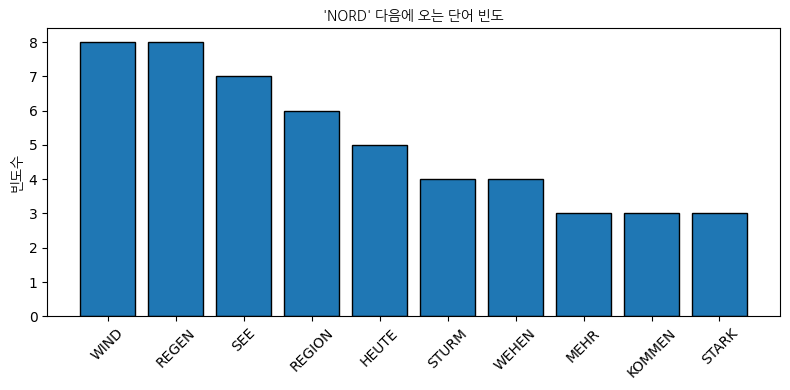

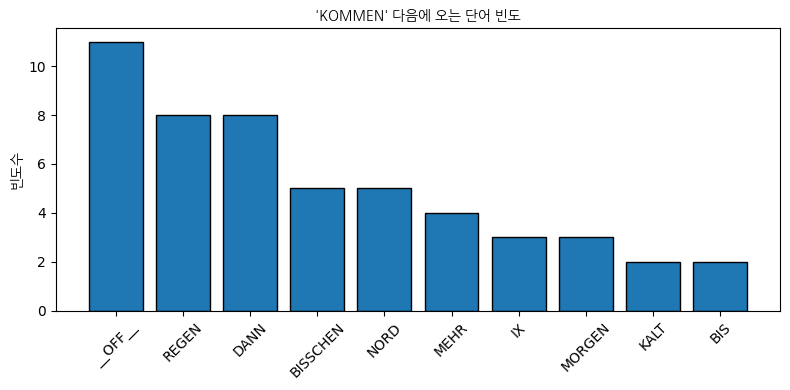

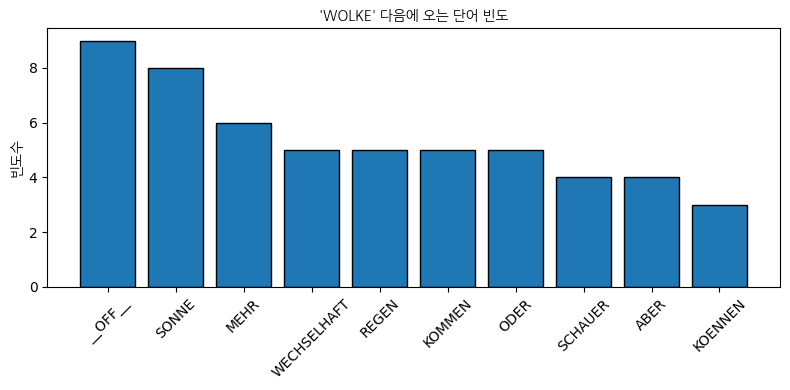

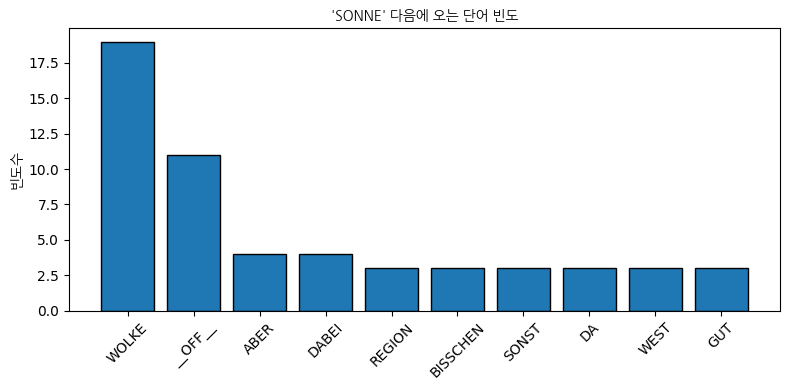

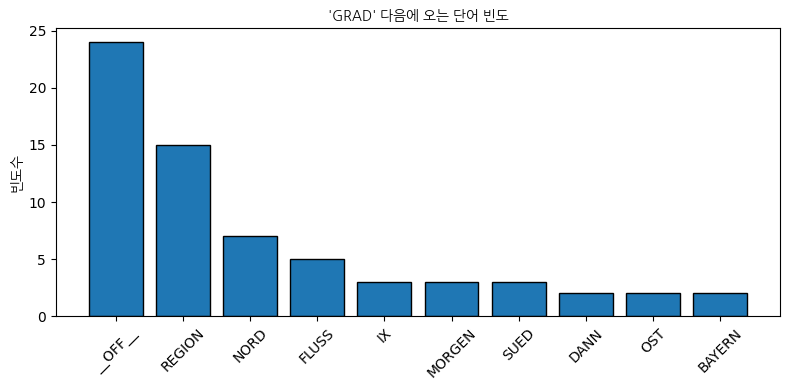

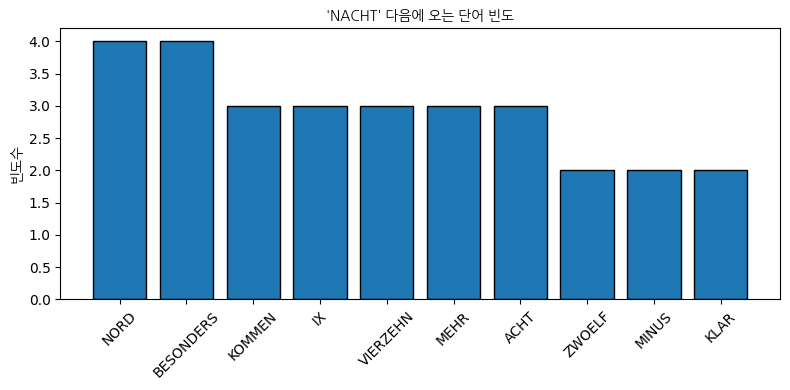

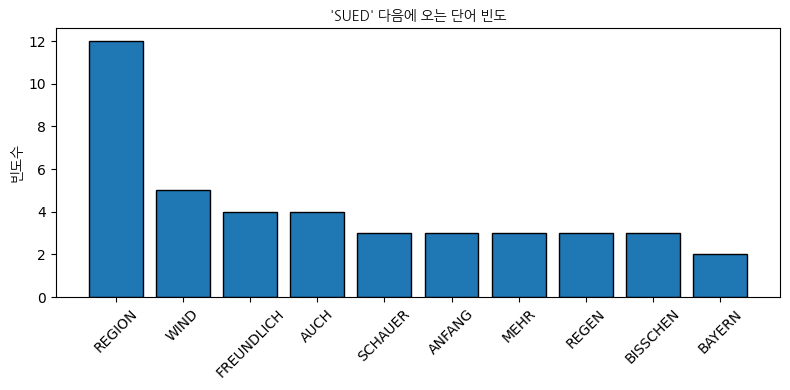

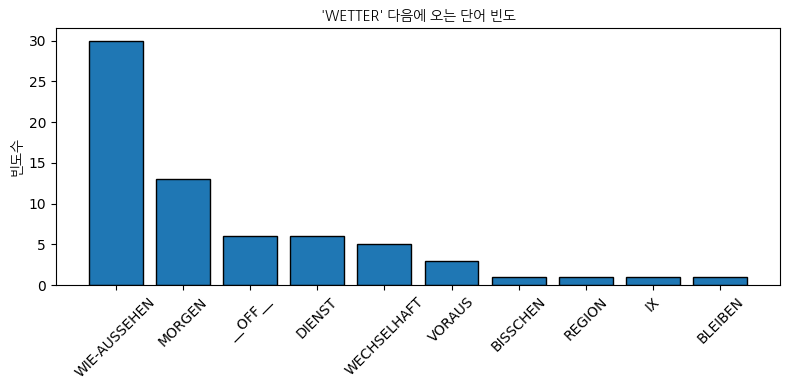

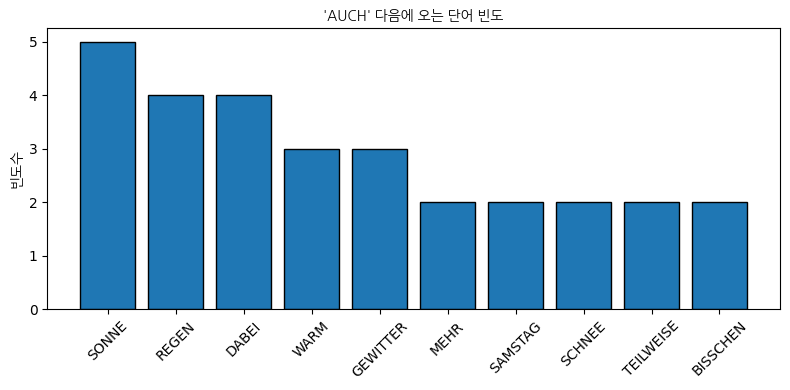

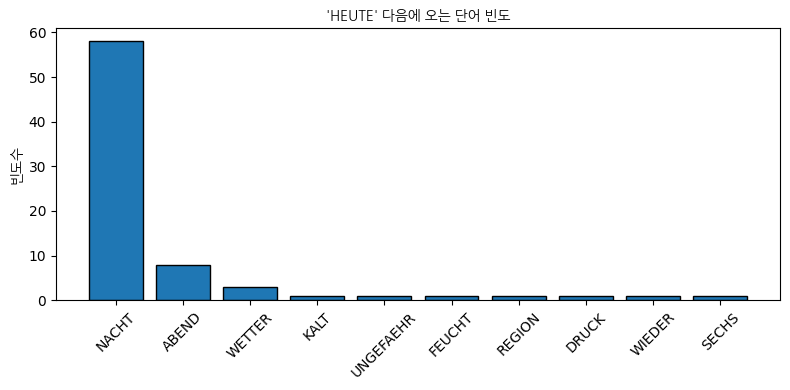

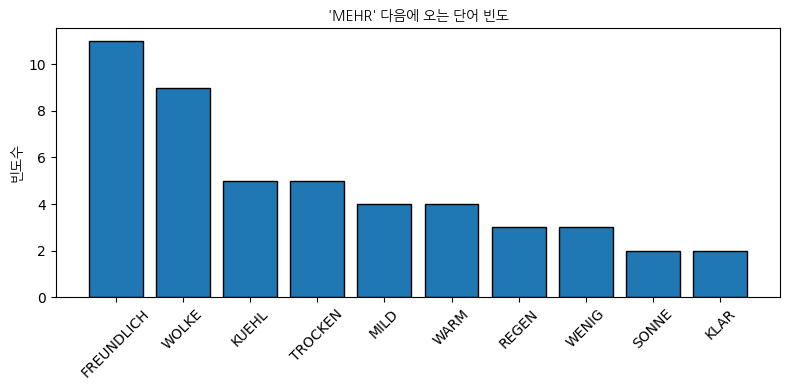

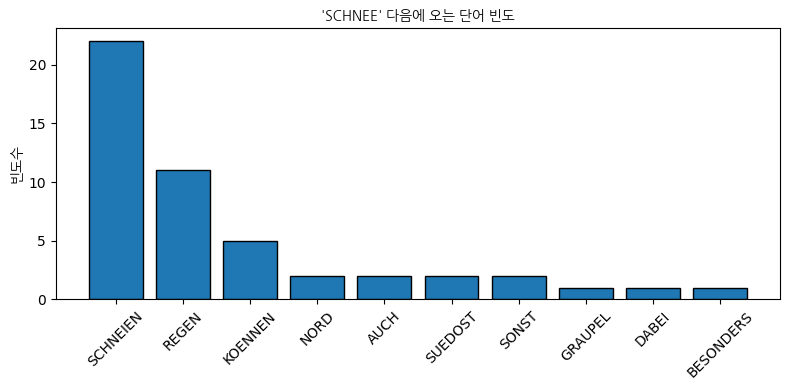

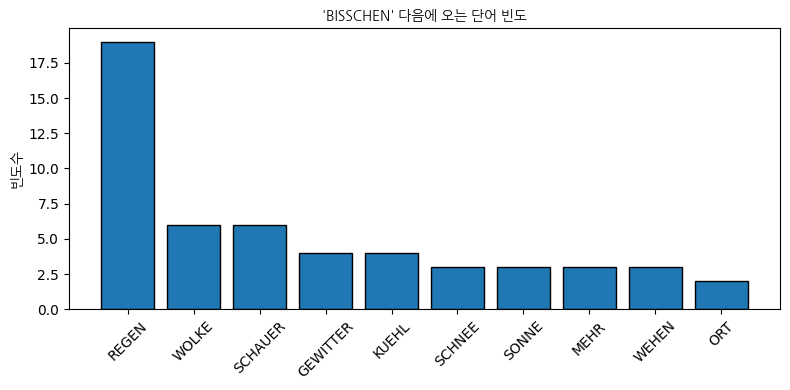

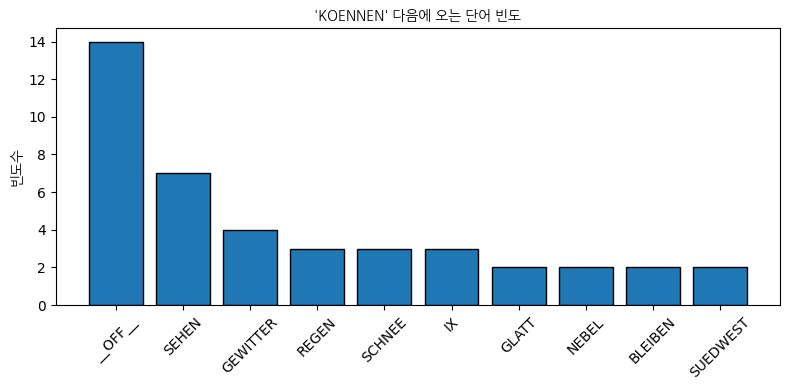

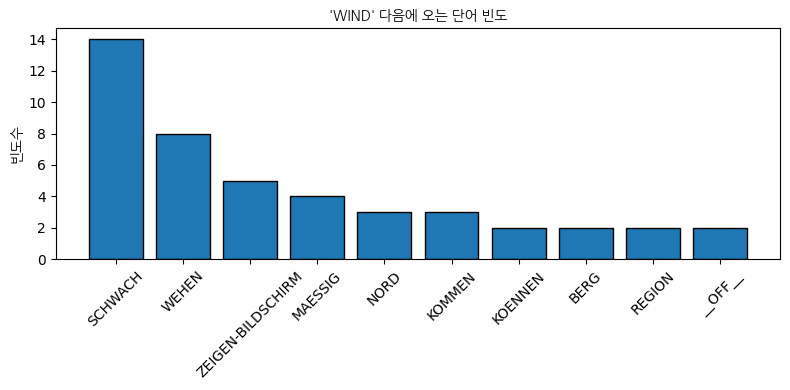

In [4]:
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# CSV 로드
df = pd.read_csv('test_frame_annotations_with_gloss.csv')

# bigram 카운터: {현재 단어: Counter({다음 단어: 빈도})}
bigram_freq = defaultdict(Counter)

# gloss 전체 순회하여 bigram 수집
for gloss in df['gloss'].dropna():
    tokens = gloss.strip().split()
    for i in range(len(tokens) - 1):
        w1, w2 = tokens[i], tokens[i+1]
        bigram_freq[w1][w2] += 1

# ✅ 상위 N개 단어 선택
top_words = sorted(bigram_freq.keys(), key=lambda k: sum(bigram_freq[k].values()), reverse=True)[:20]

# ✅ 각 단어 뒤에 오는 단어 빈도 시각화
for word in top_words:
    next_words = bigram_freq[word].most_common(10)
    if not next_words:
        continue
    labels, counts = zip(*next_words)

    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts, edgecolor='black')
    plt.title(f"'{word}' 다음에 오는 단어 빈도", fontproperties=font_prop)
    plt.ylabel("빈도수", fontproperties=font_prop)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd
from collections import defaultdict, Counter

# 파일 경로
input_path = 'test_frame_annotations_with_gloss.csv'
output_path = 'gloss_bigram_frequency.csv'

# gloss 불러오기
df = pd.read_csv(input_path)

# bigram 카운트
bigram_freq = defaultdict(Counter)

for gloss in df['gloss'].dropna():
    tokens = gloss.strip().split()
    for i in range(len(tokens) - 1):
        w1, w2 = tokens[i], tokens[i + 1]
        bigram_freq[w1][w2] += 1

# flat한 리스트로 변환
records = []
for w1, counter in bigram_freq.items():
    for w2, count in counter.items():
        records.append((w1, w2, count))

# DataFrame으로 저장
bigram_df = pd.DataFrame(records, columns=['current_word', 'next_word', 'count'])
bigram_df.sort_values(by='count', ascending=False, inplace=True)
bigram_df.to_csv(output_path, index=False)

print(f"✅ bigram 빈도수 결과 저장 완료: {output_path}")
print(bigram_df.head())


✅ bigram 빈도수 결과 저장 완료: gloss_bigram_frequency.csv
    current_word     next_word  count
794        HEUTE         NACHT     58
490       __ON__         JETZT     32
508       __ON__         HEUTE     31
581       WETTER  WIE-AUSSEHEN     30
500       __ON__        MORGEN     27


In [15]:
import numpy as np 
data = np.load('/home/jhy/SignGraph/preprocess/phoenix2014/test_info.npy', allow_pickle=True)
print(data)

{'prefix': '../dataset/phoenix2014/phoenix-2014-multisigner/features/fullFrame-210x260px', 0: {'fileid': '01April_2010_Thursday_heute_default-5', 'folder': 'test/01April_2010_Thursday_heute_default-5/1/*.png', 'signer': 'Signer04', 'label': 'ABER FREUEN  MORGEN SONNE SELTEN REGEN', 'num_frames': 132, 'original_info': '01April_2010_Thursday_heute_default-5|01April_2010_Thursday_heute_default-5/1/*.png|Signer04|ABER FREUEN  MORGEN SONNE SELTEN REGEN'}, 1: {'fileid': '01April_2010_Thursday_tagesschau_default-7', 'folder': 'test/01April_2010_Thursday_tagesschau_default-7/1/*.png', 'signer': 'Signer04', 'label': 'SAMSTAG WECHSELHAFT BESONDERS FREUNDLICH NORDOST BISSCHEN BEREICH', 'num_frames': 144, 'original_info': '01April_2010_Thursday_tagesschau_default-7|01April_2010_Thursday_tagesschau_default-7/1/*.png|Signer04|SAMSTAG WECHSELHAFT BESONDERS FREUNDLICH NORDOST BISSCHEN BEREICH'}, 2: {'fileid': '01April_2010_Thursday_tagesschau_default-8', 'folder': 'test/01April_2010_Thursday_tagesscha

In [ ]:
real_data = data.item()
print(type(real_data))  # dict
print(len(real_data))   # 예: 629
print(list(real_data.keys())[:3])  # fileid 들
# print(real_data['01April_2010_Thursday_heute_default-5'])  # 샘플 하나 확인


<class 'dict'>
630
['prefix', 0, 1]


KeyError: '01April_2010_Thursday_heute_default-5'

In [25]:
frame_counts = []
for fileid, info in real_data.items():
    folder = info['folder']
    folder_path = os.path.join(
        "/home/jhy/SignGraph/phoenix2014-release/phoenix-2014-multisigner/features/fullFrame-210x260px",
        folder
    )
    frames = glob.glob(os.path.join(folder_path, "*.png"))
    frame_counts.append(len(frames))


TypeError: string indices must be integers

In [26]:
real_data = data.item()
for k, v in list(real_data.items())[:3]:
    print(f"[{k}] => type: {type(v)} | value: {v}")


[prefix] => type: <class 'str'> | value: ../dataset/phoenix2014/phoenix-2014-multisigner/features/fullFrame-210x260px
[0] => type: <class 'dict'> | value: {'fileid': '01April_2010_Thursday_heute_default-5', 'folder': 'test/01April_2010_Thursday_heute_default-5/1/*.png', 'signer': 'Signer04', 'label': 'ABER FREUEN  MORGEN SONNE SELTEN REGEN', 'num_frames': 132, 'original_info': '01April_2010_Thursday_heute_default-5|01April_2010_Thursday_heute_default-5/1/*.png|Signer04|ABER FREUEN  MORGEN SONNE SELTEN REGEN'}
[1] => type: <class 'dict'> | value: {'fileid': '01April_2010_Thursday_tagesschau_default-7', 'folder': 'test/01April_2010_Thursday_tagesschau_default-7/1/*.png', 'signer': 'Signer04', 'label': 'SAMSTAG WECHSELHAFT BESONDERS FREUNDLICH NORDOST BISSCHEN BEREICH', 'num_frames': 144, 'original_info': '01April_2010_Thursday_tagesschau_default-7|01April_2010_Thursday_tagesschau_default-7/1/*.png|Signer04|SAMSTAG WECHSELHAFT BESONDERS FREUNDLICH NORDOST BISSCHEN BEREICH'}


In [27]:
len(list(real_data.items())
    )

630